In [1]:
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import PIL
import sys
import pickle

from tqdm import tqdm_notebook as tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
#from albumentations.pytorch import ToTensor


# Plots
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
from dataset import BuildingsDatasetH5
from train import train_model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
SEED = 238122

# Loading Data

## Transform data

In [5]:
patch_size = 256

In [6]:
dataset = BuildingsDatasetH5("data/images_{}.hdf5".format(patch_size))

## Displaying samples

In [7]:
from show import *

(256, 256, 3) (256, 256, 1)


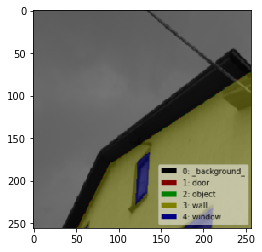

In [8]:
data = dataset[13]
show_labeled_img(data['image'], data['label'], dataset.labels)

# Validation Set

In [9]:
num_crops_per_images = pickle.load(open("data/crops_{}.p".format(patch_size), "rb" ))
crops_from_to_idx = []
from_ = 0
to = 0
for n in num_crops_per_images:
    to += n
    crops_from_to_idx.append((from_, to))
    from_ += n

In [10]:
def img_idx_to_crop_idx(indices):
    return np.array([j for i in indices for j in range(*crops_from_to_idx[i])])

In [11]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [12]:
np.random.seed(SEED)
img_indices = np.random.permutation(len(num_crops_per_images))
n_img_train, n_img_val = lenghts_split(len(num_crops_per_images), .9)
train_ind = img_idx_to_crop_idx(img_indices[:n_img_train])
train_ind = train_ind[np.random.permutation(len(train_ind))]
val_ind = img_idx_to_crop_idx(img_indices[n_img_train:])
val_ind = val_ind[np.random.permutation(len(val_ind))]

len(train_ind), len(val_ind)

(4496, 500)

In [13]:
train_dataset = Subset(dataset, train_ind)
val_dataset = Subset(dataset, val_ind)

In [14]:
batch_size = 8

In [15]:
def to_dataloader(dataset):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [16]:
dataloaders = {'train': to_dataloader(train_dataset), 'val': to_dataloader(val_dataset)}

In [17]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [18]:
dataset_sizes

{'train': 562, 'val': 63}

# Statistics

In [19]:
class_weights = {v: 0 for _, v in dataset.labels.items()}
for data in tqdm(dataloaders['train']):
    lbl = data['label'].to(device)
    for v in class_weights:
        class_weights[v] += (lbl == torch.tensor(v).to(device)).sum().float() / lbl.nelement()
        
for v in class_weights:
    class_weights[v] /= len(dataloaders['train'])

In [20]:
class_weights, sum([t.item() for _, t in class_weights.items()])

({0: tensor(0.4588, device='cuda:0'),
  1: tensor(0.0219, device='cuda:0'),
  2: tensor(0.0453, device='cuda:0'),
  3: tensor(0.4255, device='cuda:0'),
  4: tensor(0.0486, device='cuda:0')},
 1.0000000465661287)

In [21]:
weights = torch.tensor([1 - w for _, w in class_weights.items()]).to(device)
weights

tensor([0.5412, 0.9781, 0.9547, 0.5745, 0.9514], device='cuda:0')

#### todo: remove mean and std

# Using AlbuNet

In [22]:
from models import AlbuNet

In [23]:
albunet = AlbuNet(
    num_classes=len(dataset.labels),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
)

## Model details

In [24]:
%%capture catching_output
summary(albunet.to(device), input_size=dataset[0]['image'].shape)

In [25]:
summary_txt = catching_output.stdout
%store summary_txt > "models_summary/albunet_summary.txt"

Writing 'summary_txt' (str) to file 'models_summary/albunet_summary.txt'.


In [26]:
separator = "=" * 10
counter = 0
for l in iter(summary_txt.splitlines()):
    if separator in l:
        counter += 1
    if counter > 1:
        print(l)

Total params: 47,466,965
Trainable params: 47,466,965
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 547.75
Params size (MB): 181.07
Estimated Total Size (MB): 729.57
----------------------------------------------------------------


# Training

In [27]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
albunet = train_model(
    device=device,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    patch_size=patch_size,
    model=albunet,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    writer=writer,
    num_epochs=20
)

Epoch 0/19
----------



Training complete in 0m 3s
Best val Loss: 9223372036854775808.000000
Best val Acc: 0.000000


In [29]:
albunet.load_state_dict(torch.load("data/albunet_256_18.torch"))

# Showing Predictions

In [30]:
crop_to_img_list = [img_idx for img_idx, (from_, to) in enumerate(crops_from_to_idx) for i in range(from_, to)]
def crop_to_img(crop_idx):
    return crop_to_img_list[crop_idx]

val_images = sorted(list({crop_to_img(i) for i in val_ind}))
assert len(val_images) == n_img_val

In [31]:
def val_img_predict(idx):
    crops_to_show = img_idx_to_crop_idx(val_images[idx_to_show:idx_to_show+1])
    image_to_show = torch.stack([dataset[i]['image'] for i in crops_to_show])
    label_to_show = torch.stack([dataset[i]['label'] for i in crops_to_show])
    outputs = albunet(image_to_show.to(device))
    _, pred = torch.max(outputs, 1)
    return image_to_show, pred, label_to_show

In [32]:
pred_acc = []
for idx_to_show in range(len(val_images)):
    _, pred, label_to_show = val_img_predict(idx_to_show)
    pred_cmp = label_to_show.squeeze().to(device) == pred
    pred_acc.append(pred_cmp.sum().item() / pred_cmp.nelement())

In [33]:
padding = 10

In [34]:
idx_to_show = np.argmax(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(12, 0.8698590596516927)

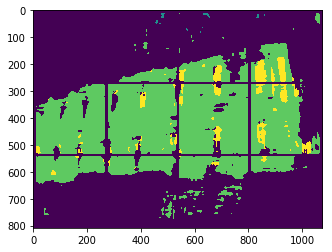

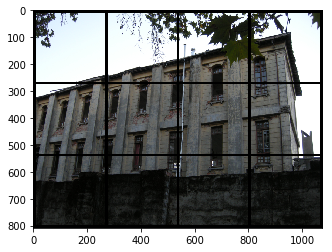

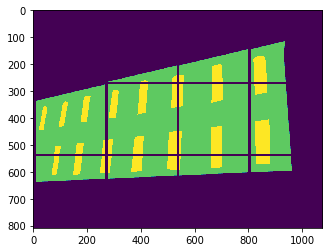

In [35]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [36]:
idx_to_show = np.argmin(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(5, 0.5104331970214844)

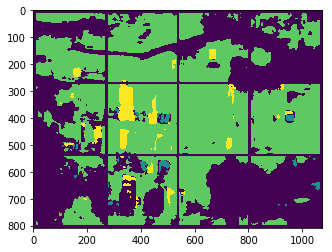

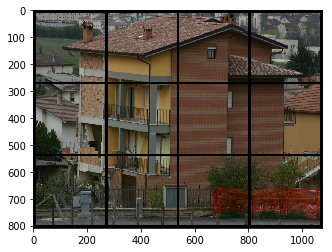

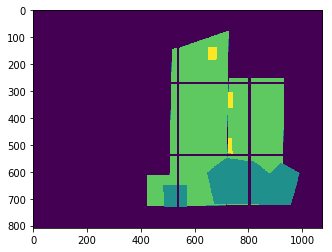

In [37]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [38]:
idx_to_show = len(pred_acc)-1
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(41, 0.8016649881998698)

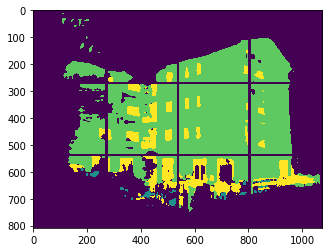

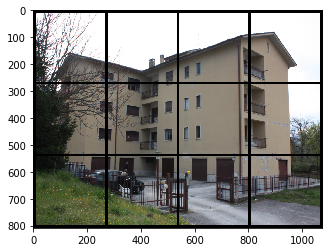

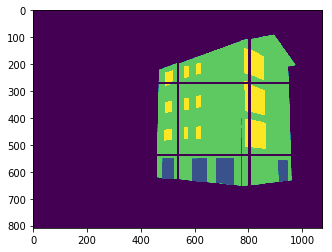

In [39]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())